## 0.0. Imports

In [30]:
import math 
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import datetime
from datetime import date

### 0.1. Helper Functions

### 0.2. Loading Data 

In [2]:
df_sales_raw = pd.read_csv('rossmann-store-sales/train.csv', low_memory = False)
df_store_raw = pd.read_csv ('rossmann-store-sales/store.csv', low_memory = False)

# merge
df_raw = pd.merge (df_sales_raw, df_store_raw, how='left', on='Store')

## 1.0. Data Description

In [3]:
df1 = df_raw.copy()

### 1.1. Rename Columns

In [4]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
             'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
             'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

#snakecase = lambda x: x.lower()
snakecase = lambda x: inflection.underscore (x)

cols_new = list((map(snakecase,cols_old)))

# rename
df1.columns = cols_new

### 1.2. Data Dimensions

In [5]:
print('Number of rows: {}'. format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


### 1.3. Data Types

In [6]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4. Check NA

In [7]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5. Fillout NA

#### 1.5.1. competition_distance   
If there is no data available, I will assume: 

1)There is no competition;

2)The closest competitor might be too far to compute. 

Filling these column with numbers way higher than the current maximum distance is a good way to represent the 2 hypothesis assumed previously.

In [8]:
df1['competition_distance'].max()

75860.0

In [9]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

#df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if pd.isna(x) else x)

# for i in range(len(df1)):
#     if pd.isna(df1.loc[i,'competition_distance']) == True:
#         df1.loc[i,'competition_distance'] = 200000

#### 1.5.2. competition_open_since_month    
Reasons for lack of data:

1)There is no competition;

2)Competition was opened but not recorded.

If data is N/A. I will copy the info in the date column into competition_open_since_month column.

In [10]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month 
                                                if math.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis = 1)

#### 1.5.3. competition_open_since_year

In [39]:
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year 
                                                if math.isnan(x['competition_open_since_year'])
                                                else x['competition_open_since_year'], axis = 1)

0          2008
1          2007
2          2006
3          2009
4          2015
           ... 
1017204    2014
1017205    2006
1017206    2013
1017207    2013
1017208    2013
Name: competition_open_since_year, Length: 1017209, dtype: int64

#### 1.5.4. promo2_since_week

In [12]:
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week 
                                     if math.isnan(x['promo2_since_week'])
                                     else x['promo2_since_week'], axis = 1)

#### 1.5.5. promo2_since_year               

In [13]:
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year 
                                     if math.isnan(x['promo2_since_year'])
                                     else x['promo2_since_year'], axis = 1)

#### 1.5.6. promo_interval
Replacing N/A with 0.

In [14]:
month_map = {1: 'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 
                                                                      1 if x['month_map'] in x['promo_interval'].split(',') else
                                                                      0, axis = 1 )

### 1.6. Change Types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.7. Descriptive Statistical

1)Understanding the business; 

2)Finding out errors.

In [17]:
num_attributes = df1.select_dtypes( include = ('int64','float64'))
cat_attributes = df1.select_dtypes( exclude = ('int64','float64','datetime64[ns]'))
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
779837,123,4,10134,1147,1,1,1,16760.0,9,2011,0,31,2013,0
676853,834,6,3903,405,1,0,0,3470.0,3,2012,0,44,2013,0


#### 1.7.1. Numerical Attributes


In [18]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# concatenate
n = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
n.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [19]:
n

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


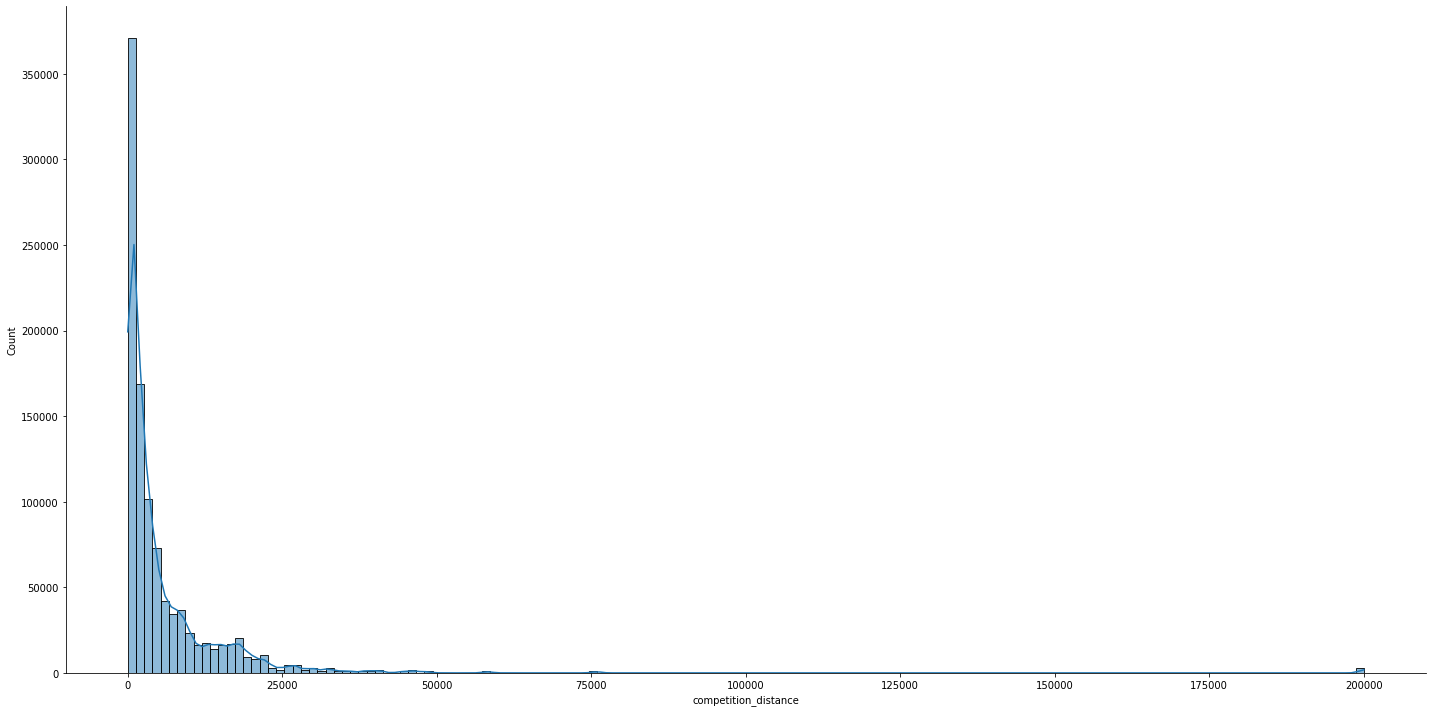

In [20]:
# sns.histplot (df1 ['sales'], kde=True, stat="density", linewidth=0, binwidth=1500)
sns.displot (df1 ['competition_distance'], kde=True, bins = 150, height = 10, aspect = 2)

#### 1.7.2. Categorical Attributes


In [21]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

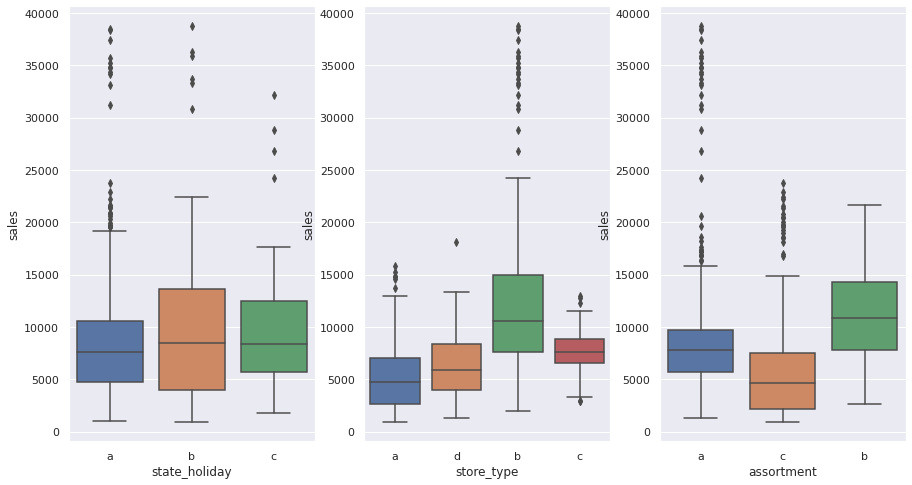

In [22]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

sns.set(rc = {'figure.figsize':(15,8)})
plt.subplot(1,3,1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot( x='assortment', y='sales', data=aux1)

## 2.0. Feature Engineering

In [37]:
df2 = df1.copy()

### 2.1. MindMap Hypothesis

The purpose is to understand how the attributes affect our main event (sales).


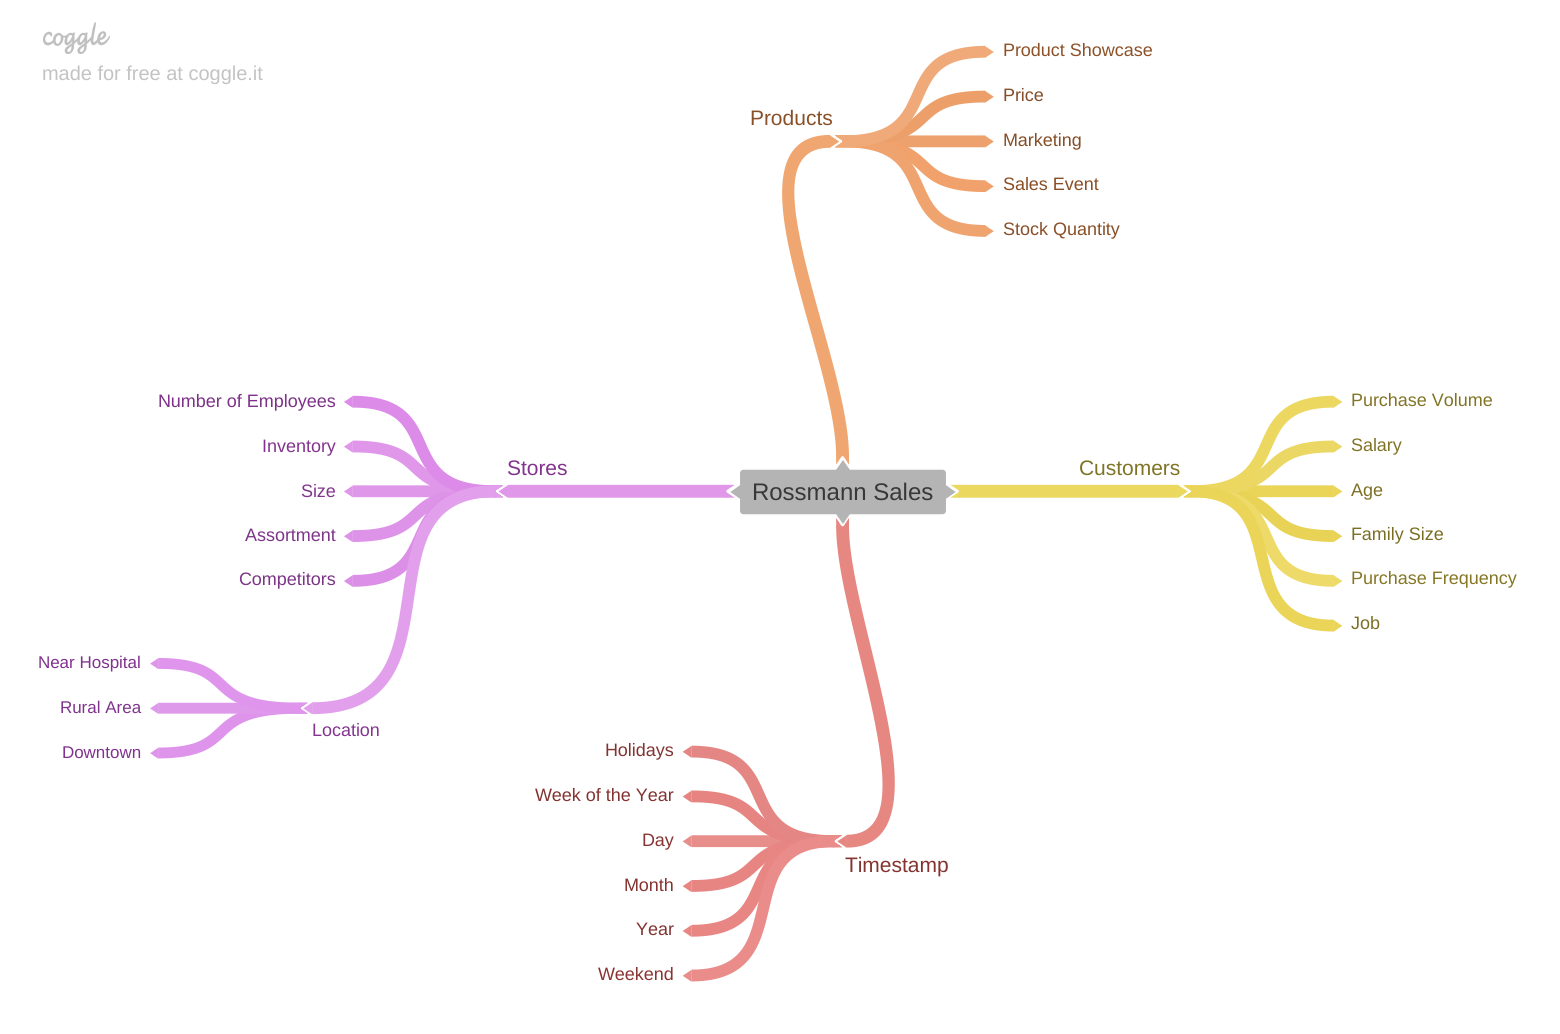

In [24]:
Image('Images/MindMap_Hypothesis.png')

### 2.1. Hyphothesis

#### 2.1.1. Store Hypothesis

**1.** Stores with more employees are more likely to sell more daily.

**2.** Stores with more Inventory are more likely to sell more daily.

**3.** Bigger stores are more likely to sell more daily.

**4.** Smaller stores are more likely to sell more daily.

**5.** Stores with more product assortment are more likely to sell more daily.

#### 2.1.2. Product Hypothesis

**1.** Products with more Marketing investment are more likely to sell more daily.

**2.** Products in Showcase are more likely to sell more daily.

**3.** Cheaper products are more likely to sell more daily.

**4.** Products on sales during a long period of time are more likely to sell more daily.

#### 2.1.3. Timestamp Hypothesis

**1.** Sales are more likely to decrease during holiday season (Stores are closed).

**2.** Sales are more likely to increase during the first 6 months of the year.

**3.** Sales are more likely to increase during weekends (Stores are open).

### 2.2. Hyphothesis Final List - Prioritizing

How? Start working with hypothesis that have data available.

**5.** Stores with more product assortment are more likely to sell more daily.

### 2.3. Feature Engineering


In [111]:
# year
df2 ['year'] = df2['date'].dt.year

# month
df2 ['month'] = df2['date'].dt.month

# day
df2 ['day'] = df2['date'].dt.day

# week of year
df2 ['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2 ['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['store_type'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' 
                                                  else 'easter_holiday' if  x=='b'  
                                                  else 'christmas' if x == 'c'
                                                  else 'regular_day')

In [112]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
